# Table of Contents
* [Wait.. but what is the Exploratory Data Analysis (EDA)?](#Wait..-but-what-is-the-Exploratory-Data-Analysis-%28EDA%29?)
* [Global functions](#Global-functions)
* [Dataset prepration](#Dataset-prepration)
* [Linear Regression](#Linear-Regression)
	* [Defining outliers as observations with high RESIDUALS](#Defining-outliers-as-observations-with-high-RESIDUALS)
* [Quadratic Regression](#Quadratic-Regression)
	* [Defining outliers as observations with high RESIDUALS](#Defining-outliers-as-observations-with-high-RESIDUALS)
	* [Quadratic regression for females](#Quadratic-regression-for-females)
* [Cluster Analysis](#Cluster-Analysis)
* [ARIMA method](#ARIMA-method)
	* [Defining outliers as observations with high RMSEs](#Defining-outliers-as-observations-with-high-RMSEs)
	* [Defining outliers as observations with high RESIDUALS](#Defining-outliers-as-observations-with-high-RESIDUALS)
* [Dataset Visualization](#Dataset-Visualization)
	* [Whole Population](#Whole-Population)
		* [General trends of Testosterone in all athletes](#General-trends-of-Testosterone-in-all-athletes)
		* [What does the distribution of log mean of testosterone look like?](#What-does-the-distribution-of-log-mean-of-testosterone-look-like?)
	* [Male population](#Male-population)
		* [General trends of testosterone in male athletes](#General-trends-of-testosterone-in-male-athletes)
		* [Testosterone distributions per athletes](#Testosterone-distributions-per-athletes)
	* [Female population](#Female-population)
		* [General trends of testosterone in female athletes](#General-trends-of-testosterone-in-female-athletes)
		* [Testosterone distributions per athletes](#Testosterone-distributions-per-athletes)
* [Some snippets for clarification](#Some-snippets-for-clarification)
	* [An example to show the difference between DTW and Euclidian distances](#An-example-to-show-the-difference-between-DTW-and-Euclidian-distances)
* [Other Questions](#Other-Questions)
	* [Is there any difference in mean of testosterone between male/female athletes?](#Is-there-any-difference-in-mean-of-testosterone-between-male/female-athletes?)
	* [Does testosterone levels are being affected in a different way between male/female athletes?](#Does-testosterone-levels-are-being-affected-in-a-different-way-between-male/female-athletes?)


# Wait.. but what is the Exploratory Data Analysis (EDA)?

> In statistics, exploratory data analysis (EDA) is an approach to analyzing data sets to summarize their main characteristics, often with visual methods. A statistical model can be used or not, but primarily EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing task. Exploratory data analysis was promoted by John Tukey to encourage statisticians to explore the data, and possibly formulate hypotheses that could lead to new data collection and experiments. EDA is different from initial data analysis (IDA),[1] which focuses more narrowly on checking assumptions required for model fitting and hypothesis testing, and handling missing values and making transformations of variables as needed. EDA encompasses IDA. __Wikipedia__

In [1]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from pandas import DataFrame
init_notebook_mode(connected=True)
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

from scipy.optimize import curve_fit
from scipy.stats import norm
from math import sqrt

from sklearn.cluster import AgglomerativeClustering
import colorlover as cl

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from tqdm import tqdm_notebook

# Global functions

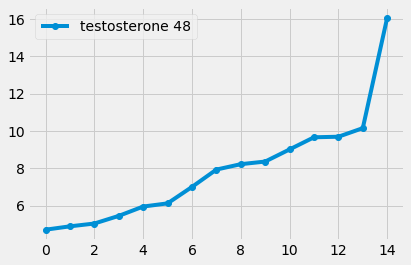

In [49]:
show_testosterone_and_predictions(48, show_prediction=False)

In [2]:
def show_testosterone_and_predictions(index, model_coefs=None, is_male=True, show_prediction=True, isARIMA=True, abnormal_indices=None):
    y = male_testosterones[index] if is_male else female_testosterones[index]
    x = np.arange(len(y))
    
    plt.plot(x, y, marker='o', label="testosterone {}".format(index))
    
    if show_prediction:
        try:
            y_hat = model_coefs[index][0] + model_coefs[index][1] * x + model_coefs[index][2] * (x**2)
        except:
            y_hat = model_coefs[index][0] + model_coefs[index][1] * x
            
        plt.plot(x, y_hat, marker='o', label="prediction {}".format(index))
    
    if abnormal_indices is not None:
        
        if isARIMA:
            # since the abnormal indices are relative to the length of the test set,
            # it requires to find the abnormal indices based on the whole sequence
            # here we consider 66% of whole sequence as train and the rest as test

            train_size = int(len(y) * 0.66)
            actual_indices = train_size + np.array(abnormal_indices)
        else:
            actual_indices = abnormal_indices
            
        plt.scatter(actual_indices, y.values[actual_indices], c='r', marker='*', s=256, zorder=20)
        
    plt.legend()

# Dataset prepration

In [3]:
data = DataFrame.from_csv("./testosterone_levels.csv")

# whole population
testosterones = [p.Testosterone for _, p in data.groupby("Person")]
mean_std = np.array([[t.mean(), t.std()] for t in testosterones])
cv = (mean_std[:, 1] / mean_std[:, 0]) * 100

# gender specific population
gender = data.groupby("Person").first()['F1']
male = data[data['F1'] == 1]
female = data[data['F1'] == 2]
male_testosterones = [p.Testosterone for _, p in male.groupby("Person")]
female_testosterones = [p.Testosterone for _, p in female.groupby("Person")]

mean_std_male = np.array([[t.mean(), t.std()] for t in male_testosterones])
mean_std_female = np.array([[t.mean(), t.std()] for t in female_testosterones])
cv_male = (mean_std_male[:, 1] / mean_std_male[:, 0]) * 100
cv_female = (mean_std_female[:, 1] / mean_std_female[:, 0]) * 100

# Linear Regression

In [4]:
model = Pipeline([('poly', PolynomialFeatures(degree=1)),('linear', LinearRegression(fit_intercept=False))])

errors = []
residuals = []
linear_coefs = []
for y in male_testosterones:
    x = np.arange(len(y))
    model = model.fit(np.arange(len(y))[:, np.newaxis], y)
    y_hat = model.named_steps['linear'].coef_[0] + model.named_steps['linear'].coef_[1] * x
    residual = y - y_hat
    error = np.mean((residual) ** 2) ** .5
    errors.append(error)
    residuals.append(residual)
    linear_coefs.append(model.named_steps['linear'].coef_)

data = [go.Box(y=residual, hoverinfo=residual.index[0]) for residual in residuals]
iplot(data)

## Defining outliers as observations with high RESIDUALS

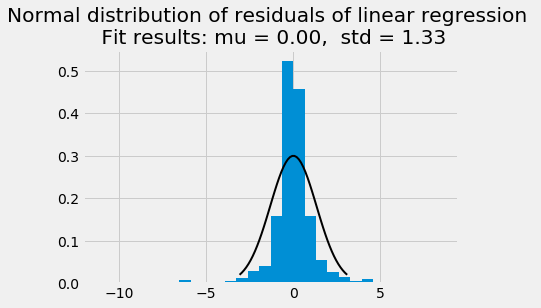

Abnormal Male Cases (based on the residuals of the linear fit):
Number of abnormal cases: 18
Number of abnormal observations 66


,index,sequ,Residual T
0,1.0,9.0,2.258727
1,7.0,0.0,2.466727
2,7.0,5.0,-2.212970
3,7.0,6.0,-2.906909
4,7.0,7.0,-3.160848
5,7.0,9.0,6.861273
6,11.0,3.0,-2.399455
7,11.0,4.0,-6.461818
8,11.0,6.0,3.963455
9,11.0,7.0,3.881091


In [5]:
male_residuals = np.array([[i, s, r] for i, res in enumerate(residuals) for s, r in enumerate(res)])

mu_residual, sigma_residual = norm.fit(male_residuals[:,2])

x = np.linspace(norm.ppf(0.01, loc=mu_residual, scale=sigma_residual), norm.ppf(0.99, loc=mu_residual, scale=sigma_residual))
p = norm.pdf(x, mu_residual, sigma_residual)
plt.plot(x, p, 'k', linewidth=2)
plt.hist(male_residuals[:,2], normed=True, bins=30)

title = "Normal distribution of residuals of linear regression \n Fit results: mu = %.2f,  std = %.2f" % (mu_residual, sigma_residual)
plt.title(title)
plt.show()

abnormal_high = norm.ppf(0.95, loc=mu_residual, scale=sigma_residual)
abnormal_low = norm.ppf(0.05, loc=mu_residual, scale=sigma_residual)
abnormal_cases = [res  for res in male_residuals if res[2] >= abnormal_high or res[2] <= abnormal_low]
abnormals = DataFrame(abnormal_cases, columns=['index', "sequ", 'Residual T'])
print("Abnormal Male Cases (based on the residuals of the linear fit):")
print("Number of abnormal cases:", len(abnormals['index'].unique()))
print("Number of abnormal observations", len(abnormals))
abnormals

>Using residuals of linear model we found __18__ abnormal cases from __66__ observations. Note that the residuals of these observations fall outside of the 95% percentile.

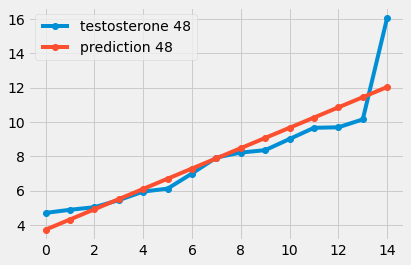

In [50]:
# for t in [(int(key), df['sequ'].astype("int").values) for key, df in abnormals.groupby('index')]:
#     show_testosterone_and_predictions(t[0], linear_coefs, show_prediction=True, abnormal_indices=t[1], isARIMA=False)
#     plt.show()
show_testosterone_and_predictions(48, linear_coefs, show_prediction=True)

In [7]:
total_var = [np.var(res) for res in residuals]
DataFrame(total_var).describe()

,0
count,107.000000
mean,1.353844
std,3.459832
min,0.000646
25%,0.104300
50%,0.282944
75%,1.048539
max,28.863435


It seems that there are some athletes that do not follow the linear model. This can be confirmed by that fact that for those athletes the linear model has a large variance in the residuals. Another fact that can be easily implied by the distribution of residuals is that we can detect abnormal observations (test results) which fall outside the 99% percentile of the residual distribution. By visually inspecting such cases we confirmed that those test results show a sudden increase compared to the general trend of observations. The next question is that whether we can model rest of athletes with high variance with a non-linear model.

# Quadratic Regression

In [53]:
model_quad = Pipeline([('poly', PolynomialFeatures(degree=2)),('linear', LinearRegression(fit_intercept=False))])

residuals_quad = []
quad_coefs = []
for y in male_testosterones:
    x = np.arange(len(y))
    model_quad = model_quad.fit(np.arange(len(y))[:, np.newaxis], y)
    y_hat_quad = model_quad.named_steps['linear'].coef_[0] + model_quad.named_steps['linear'].coef_[1] * x + model_quad.named_steps['linear'].coef_[2] * (x** 2)
    residual_quad = y - y_hat_quad
    quad_coefs.append(model_quad.named_steps['linear'].coef_) 
    residuals_quad.append(residual_quad)

data = [go.Box(y=residual_quad, hoverinfo=residual_quad.index[0]) for residual_quad in residuals_quad]
iplot(data)

## Defining outliers as observations with high RESIDUALS

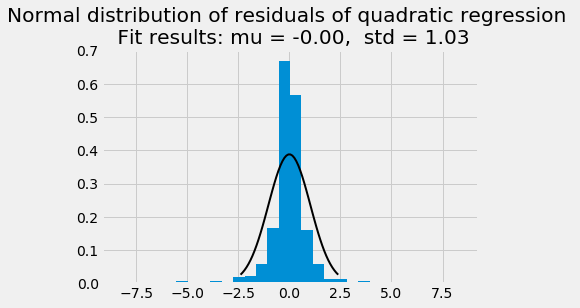

Number of abnormal cases: 20
Number of abnormal observations 57
Abnormal Male Cases (based on the residuals of the quadratic fit):


,index,sequ,Residual T
0,7.0,4.0,1.763697
1,7.0,7.0,-2.550167
2,7.0,8.0,-2.246152
3,7.0,9.0,3.197182
4,8.0,8.0,1.704515
5,11.0,3.0,-2.374682
6,11.0,4.0,-6.428788
7,11.0,6.0,3.988227
8,11.0,7.0,3.889348
9,11.0,9.0,-3.593182


In [54]:
male_residuals = np.array([[i, s, r] for i, res in enumerate(residuals_quad) for s, r in enumerate(res)])
mu_residual, sigma_residual = norm.fit(male_residuals[:,2])

x = np.linspace(norm.ppf(0.01, loc=mu_residual, scale=sigma_residual), norm.ppf(0.99, loc=mu_residual, scale=sigma_residual))
p = norm.pdf(x, mu_residual, sigma_residual)
plt.plot(x, p, 'k', linewidth=2)
plt.hist(male_residuals[:,2], normed=True, bins=30)
title = "Normal distribution of residuals of quadratic regression \n Fit results: mu = %.2f,  std = %.2f" % (mu_residual, sigma_residual)
plt.title(title)
plt.show()

abnormal_high = norm.ppf(0.95, loc=mu_residual, scale=sigma_residual)
abnormal_low = norm.ppf(0.05, loc=mu_residual, scale=sigma_residual)
abnormal_cases = [res  for res in male_residuals if res[2] >= abnormal_high or res[2] <= abnormal_low]
abnormals = DataFrame(abnormal_cases, columns=['index', "sequ", 'Residual T'])
print("Number of abnormal cases:", len(abnormals['index'].unique()))
print("Number of abnormal observations", len(abnormals))
print("Abnormal Male Cases (based on the residuals of the quadratic fit):")
abnormals

>Using residuals of quadratic model we found __20__ abnormal cases from __57__ observations. Note that the residuals of these observations fall outside of the 95% percentile.

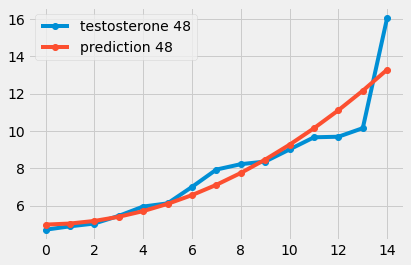

In [55]:
# for t in [(int(key), df['sequ'].astype("int").values) for key, df in abnormals.groupby('index')]:
#     show_testosterone_and_predictions(t[0], model_coefs=quad_coefs, abnormal_indices=t[1], isARIMA=False)
#     plt.show()
show_testosterone_and_predictions(48, quad_coefs, show_prediction=True, isARIMA=False)

In [12]:
total_var_quad = [np.var(res) for res in residuals_quad]
DataFrame(total_var_quad).describe()

,0
count,107.000000
mean,0.774351
std,2.449339
min,0.000633
25%,0.035161
50%,0.160113
75%,0.501466
max,22.543074


By increasing the flexibility of the model from linear to non-linear, obviously, the variance is decreased. That is the model is able to fit more observations and this might result in considering outlier points less than before. The athletes for which the box plot of residuals shows some outlier points (in non-linear case) there is a strong indication that such observations are abnormal. We have confirmed this fact by visually inspecting these cases.

## Quadratic regression for females

In [13]:
model_quad = Pipeline([('poly', PolynomialFeatures(degree=2)),('linear', LinearRegression(fit_intercept=False))])

residuals_quad = []
quad_coefs = []
for y in female_testosterones:
    x = np.arange(len(y))
    model_quad = model_quad.fit(np.arange(len(y))[:, np.newaxis], y)
    y_hat_quad = model_quad.named_steps['linear'].coef_[0] + model_quad.named_steps['linear'].coef_[1] * x + model_quad.named_steps['linear'].coef_[2] * (x** 2)
    residual_quad = y - y_hat_quad
    quad_coefs.append(model_quad.named_steps['linear'].coef_) 
    residuals_quad.append(residual_quad)

data = [go.Box(y=residual_quad, hoverinfo=residual_quad.index[0]) for residual_quad in residuals_quad]
iplot(data)

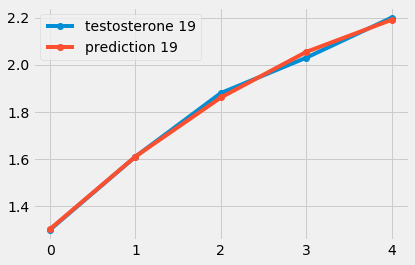

In [14]:
show_testosterone_and_predictions(19, quad_coefs, False)

Same as male athlete using non-linear fits for female athlets can almost perfectly describe the trends of testosterones. Athletes with high variance shows abnormal patterns.

# Cluster Analysis

Clustering testosterone series using Euclidian distance as the measure of similarity. To accomplish this two series are required to have equal length. In case of unequal-length series we shorten the longer series to be equal to the shorter one.

In [38]:
num_classes = 5

In [39]:
def euclid_dist(t1,t2):
    if len(t1) < len(t2):
        t2 = t2[:len(t1)]
    else:
        t1 = t1[:len(t2)]
        
    return sqrt(sum((t1-t2)**2))

In [40]:
X = [test.values for test in male_testosterones]

dist = np.zeros((len(X), len(X)))

for i, x in enumerate(X):
    for j, y in enumerate(X):
        dist[i,j] = euclid_dist(x, y)

In [41]:
model = AgglomerativeClustering(affinity='precomputed', n_clusters=num_classes, linkage='complete').fit(dist)

In [42]:
plotData = []
lines = []
c = cl.scales['12']['qual']['Paired']
for i, test in enumerate(male_testosterones):
    plotData.append(go.Scatter(
    x= np.arange(len(test)),
    y= test.values,
    name = 'class {}'.format(model.labels_[i]),
    mode = 'lines+markers',
    marker = dict(color= c[model.labels_[i]]),
    showlegend = False))

layout = dict(title = 'Male population testosterone',
              xaxis = dict(title = 'Samples'),
              yaxis = dict(title = 'T'))

iplot(dict(data=plotData, layout=layout))

# ARIMA method

In [20]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
from sklearn.metrics import mean_squared_error

/home/iss/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



In [58]:
def evaluate_arima_model_test(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    residuals = np.array(test) - np.array(predictions).flatten()
    rmse = sqrt(mean_squared_error(test, predictions))
    return predictions

In [21]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    residuals = np.array(test) - np.array(predictions).flatten()
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse, residuals

In [22]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse, _ = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return best_cfg

In [23]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

In [24]:
residuals = []
errors = []
for X in tqdm_notebook(male_testosterones):
    best_conf = evaluate_models(X.values, p_values, d_values, q_values)
    rmse, residual = evaluate_arima_model(X.values, best_conf)
    residuals.append(residual)
    errors.append(rmse)

A Jupyter Widget

Best ARIMA(0, 1, 0) RMSE=0.151
Best ARIMA(1, 2, 0) RMSE=1.667
Best ARIMA(1, 1, 0) RMSE=0.474
Best ARIMA(1, 0, 0) RMSE=0.195
Best ARIMA(0, 2, 1) RMSE=0.662
Best ARIMA(0, 1, 0) RMSE=0.668
Best ARIMA(0, 1, 1) RMSE=0.264
Best ARIMA(0, 2, 0) RMSE=2.856
Best ARIMA(1, 1, 0) RMSE=2.125
Best ARIMA(0, 1, 0) RMSE=1.115
Best ARIMA(0, 1, 0) RMSE=0.416
Best ARIMA(0, 2, 0) RMSE=3.249
Best ARIMA(0, 1, 2) RMSE=1.083
Best ARIMA(2, 1, 0) RMSE=1.842
Best ARIMA(0, 1, 0) RMSE=1.480
Best ARIMA(0, 1, 2) RMSE=0.515
Best ARIMA(0, 1, 0) RMSE=5.600
Best ARIMA(0, 2, 0) RMSE=0.659
Best ARIMA(0, 1, 0) RMSE=2.191
Best ARIMA(0, 1, 0) RMSE=0.133
Best ARIMA(0, 1, 0) RMSE=0.469
Best ARIMA(0, 1, 0) RMSE=0.755
Best ARIMA(0, 2, 0) RMSE=0.567
Best ARIMA(0, 1, 1) RMSE=0.221
Best ARIMA(0, 0, 0) RMSE=1.608
Best ARIMA(0, 1, 0) RMSE=0.749
Best ARIMA(0, 2, 0) RMSE=0.804
Best ARIMA(0, 1, 0) RMSE=0.280
Best ARIMA(0, 1, 1) RMSE=1.262
Best ARIMA(0, 1, 1) RMSE=1.227
Best ARIMA(0, 2, 0) RMSE=1.254
Best ARIMA(0, 1, 0) RMSE=1.667
Best ARI

In [25]:
plotData = [go.Box(y=res) for res in residuals]
iplot(plotData)

## Defining outliers as observations with high RMSEs

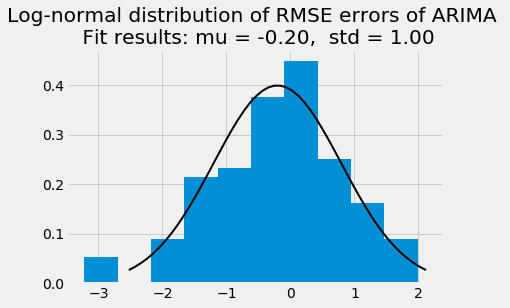

Number of abnormal cases: 5
Number of abnormal observations 5
Abnormal Male Cases (based on the RMSE errors of the ARIMA fit):


,index
0,16
1,53
2,85
3,94
4,99


In [26]:
mu, sigma = norm.fit(np.log(errors))

x = np.linspace(norm.ppf(0.01, loc=mu, scale=sigma), norm.ppf(0.99, loc=mu, scale=sigma))
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'k', linewidth=2)
title = "Log-normal distribution of RMSE errors of ARIMA \n Fit results: mu = %.2f,  std = %.2f" % (mu, sigma)
plt.title(title)
plt.hist(np.log(errors), normed=True)
plt.show()

abnormal_high = norm.ppf(0.95, loc=mu, scale=sigma)
abnormal_cases = [i  for i, e in enumerate(errors) if np.log(e) >= abnormal_high]
abnormals = DataFrame(abnormal_cases, columns=['index'])
print("Number of abnormal cases:", len(abnormals['index'].unique()))
print("Number of abnormal observations", len(abnormals))
print("Abnormal Male Cases (based on the RMSE errors of the ARIMA fit):")
abnormals

>ALL above cases are confirm to be abnormal. So this method found only __5__ abnormal cases.

## Defining outliers as observations with high RESIDUALS

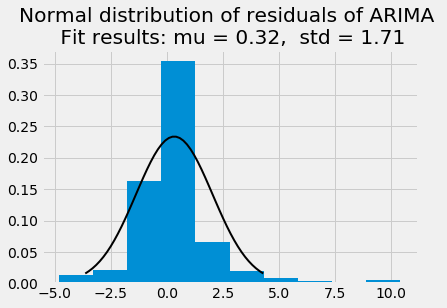

Number of abnormal cases: 15 Number of abnormal observations 17
Abnormal Male Cases (based on the residuals of the ARIMA fit):


,index,sequ,Residual T
0,7.0,3.0,5.215714
1,8.0,2.0,4.128853
2,13.0,2.0,3.674892
3,16.0,0.0,10.407500
4,16.0,3.0,3.912857
5,34.0,2.0,3.294286
6,35.0,1.0,5.474405
7,39.0,2.0,3.451667
8,40.0,2.0,3.896370
9,48.0,5.0,5.234959


In [48]:
all_residuals = np.array([[i, s, r] for i, res in enumerate(residuals) for s, r in enumerate(res)])
mu_residual, sigma_residual = norm.fit(all_residuals[:,2])

x = np.linspace(norm.ppf(0.01, loc=mu_residual, scale=sigma_residual), norm.ppf(0.99, loc=mu_residual, scale=sigma_residual))
p = norm.pdf(x, mu_residual, sigma_residual)
plt.plot(x, p, 'k', linewidth=2)
plt.hist(all_residuals[:,2], normed=True)

title = "Normal distribution of residuals of ARIMA \n Fit results: mu = %.2f,  std = %.2f" % (mu_residual, sigma_residual)
plt.title(title)
plt.show()

abnormal_high = norm.ppf(0.95, loc=mu_residual, scale=sigma_residual)
abnormal_cases = [res  for res in all_residuals if res[2] >= abnormal_high]
abnormals = DataFrame(abnormal_cases, columns=['index', "sequ", 'Residual T'])
print("Number of abnormal cases:", len(abnormals['index'].unique()), "Number of abnormal observations", len(abnormals))
print("Abnormal Male Cases (based on the residuals of the ARIMA fit):")

abnormals

>Using residuals we found many more abnormal cases (__15__) and observations (__17__) comapred to the method by which abnormals are found using RMSEs

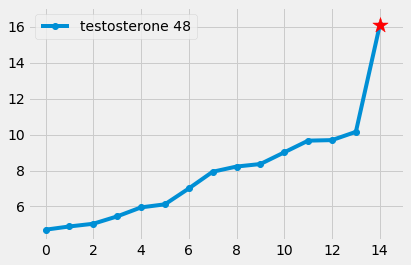

In [47]:
show_testosterone_and_predictions(48, show_prediction=False, abnormal_indices=[5])

In [29]:
total_var_quad = [np.var(res) for res in residuals]
DataFrame(total_var_quad).describe()

,0
count,107.000000
mean,1.898526
std,4.174418
min,0.001111
25%,0.066133
50%,0.367034
75%,1.410484
max,22.250061


# Dataset Visualization

## Whole Population

### General trends of Testosterone in all athletes

In [30]:
plotData = []
for test in testosterones:
    plotData.append(go.Scatter(x= np.arange(len(test)), y= test.values, name=testosterones[0].index[0], showlegend=False)) 

layout = dict(title = 'Whole population testosterone',
              xaxis = dict(title = 'Samples'),
              yaxis = dict(title = 'T'))

iplot(dict(data=plotData, layout=layout))

### What does the distribution of log mean of testosterone look like?

mu1: 0.65, mu2: 2.31, sigma1: 0.32, sigma2: 0.48


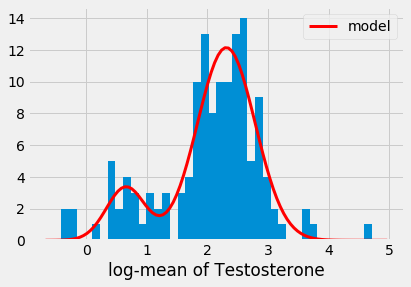

In [31]:
def bimodal(x, mu1, sigma1, a, mu2, sigma2, b):
    return a * norm.pdf(x, loc=mu1, scale=sigma1) + b * norm.pdf(x, loc=mu2, scale=sigma2)

y, x, _ = plt.hist(np.log(mean_std[:, 0]), bins=40)

x = (x[1:] + x[:-1]) / 2  # for len(x)==len(y)

expected = (.9, .3, 5, 2, .5, 25)
params, cov = curve_fit(bimodal, x, y, expected)

x_min, x_max = plt.xlim()
x_range = np.linspace(x_min, x_max, 100)

plt.plot(x_range, bimodal(x_range, *params), color='red', lw=3, label='model')
plt.xlabel("log-mean of Testosterone")

plt.legend()
print("mu1: %.2f, mu2: %.2f, sigma1: %.2f, sigma2: %.2f" % (params[0], params[3], params[1], params[4]))

## Male population

### General trends of testosterone in male athletes

In [32]:
plotData = []
for test in male_testosterones:
    plotData.append(go.Scatter(x= np.arange(len(test)), y= test.values, name=test.index[0], showlegend=False)) 

layout = dict(title = 'Male population testosterone',
              xaxis = dict(title = 'Samples'),
              yaxis = dict(title = 'T'))

iplot(dict(data=plotData, layout=layout))

### Testosterone distributions per athletes

In [33]:
plotData = []
for test in male_testosterones:
    plotData.append(go.Box(y= test, showlegend=False))
layout = dict(title = 'Distribution testosterone male athletes ',
              xaxis = dict(title = 'Athletes'),
              yaxis = dict(title = 'T'))

iplot(dict(data=plotData, layout=layout))

## Female population

### General trends of testosterone in female athletes

In [34]:
plotData = []
for test in female_testosterones:
    plotData.append(go.Scatter(x= np.arange(len(test)), y= test.values, name=testosterones[0].index[0], showlegend=False)) 

layout = dict(title = 'Female population testosterone',
              xaxis = dict(title = 'Samples'),
              yaxis = dict(title = 'T'))

iplot(dict(data=plotData, layout=layout))

### Testosterone distributions per athletes

In [35]:
plotData = []
for test in female_testosterones:
    plotData.append(go.Box(y= test, showlegend=False))
layout = dict(title = 'Distribution testosterone female athletes ',
              xaxis = dict(title = 'Athletes'),
              yaxis = dict(title = 'T'))

iplot(dict(data=plotData, layout=layout))

# Some snippets for clarification

## An example to show the difference between DTW and Euclidian distances

In [36]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

a0 = male_testosterones[0].values
a1 = male_testosterones[1].values
a43 = male_testosterones[43].values

distance0_1, path = fastdtw(a0, a1, dist=euclidean)
distance0_43, path = fastdtw(a0, a43, dist=euclidean)
distance1_43, path = fastdtw(a1, a43, dist=euclidean)
print("fastdtw distance:")
print("distance a0 and a1: {}".format(distance0_1))
print("distance a0 and a43: {}".format(distance0_43))
print("distance a1 and a43: {}".format(distance1_43))
print("\n############\n")
distance0_1_euclid = euclid_dist(a0, a1)
distance0_43_euclid = euclid_dist(a0, a43)
distance1_43_euclid = euclid_dist(a1, a43)
print("Euclidian distance:")
print("distance a0 and a1: {}".format(distance0_1_euclid))
print("distance a0 and a43: {}".format(distance0_43_euclid))
print("distance a1 and a43: {}".format(distance1_43_euclid))

fastdtw distance:
distance a0 and a1: 68.81
distance a0 and a43: 41.42000000000001
distance a1 and a43: 27.14999999999999

############

Euclidian distance:
distance a0 and a1: 23.01322445899314
distance a0 and a43: 4.6731680902788
distance a1 and a43: 18.572571173642057


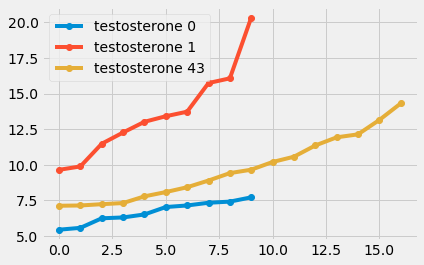

In [37]:
show_testosterone_and_predictions(0, show_prediction=False)
show_testosterone_and_predictions(1, show_prediction=False)
show_testosterone_and_predictions(43, show_prediction=False)

# Other Questions

## Is there any difference in mean of testosterone between male/female athletes?

## Does testosterone levels are being affected in a different way between male/female athletes?